# <span style="color:darkorange; font-size:50px">**Práctica: clasificación de Perros y Gatos**</span>
## Con la base de datos de **cats vs. dogs** de **Kaggle**

# <span style="color:darkorange; font-size:28px"> *Álvaro González Sánchez*
#### Modelos de Redes Neuronales, **Máster en Metodología de las Ciencias del Comportamiento y de la Salud**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [11]:
import os
import random
import shutil
from pathlib import Path

# Ruta de origen
source_dir = "/Users/alvarogonzalez/Downloads/dogs-vs-cats-2/train"

# Ruta base del nuevo dataset
target_base = "/Users/alvarogonzalez/Downloads/dogs-vs-cats-2/dataset"

# Cantidades
samples_per_class = 3000
split_ratio = [0.7, 0.15, 0.15]  # train, val, test

# Función para copiar imágenes según división
def copy_images(prefix, label_name):
    images = [f for f in os.listdir(source_dir) if f.startswith(prefix)]
    selected = random.sample(images, samples_per_class)

    train_count = int(split_ratio[0] * samples_per_class)
    val_count = int(split_ratio[1] * samples_per_class)

    splits = {
        "train": selected[:train_count],
        "val": selected[train_count:train_count + val_count],
        "test": selected[train_count + val_count:]
    }

    for split_name, file_list in splits.items():
        dst_dir = os.path.join(target_base, split_name, label_name)
        os.makedirs(dst_dir, exist_ok=True)
        for fname in file_list:
            shutil.copy(
                os.path.join(source_dir, fname),
                os.path.join(dst_dir, fname)
            )
        print(f"{len(file_list)} imágenes de {label_name} copiadas a {split_name}/")

# Fijar semilla para reproducibilidad
random.seed(42)

# Procesar gatos y perros
copy_images("cat", "cats")
copy_images("dog", "dogs")

2100 imágenes de cats copiadas a train/
450 imágenes de cats copiadas a val/
450 imágenes de cats copiadas a test/
2100 imágenes de dogs copiadas a train/
450 imágenes de dogs copiadas a val/
450 imágenes de dogs copiadas a test/


In [19]:
# Carga sin procesar aún
raw_train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    class_names=class_names,
    shuffle=True
)

print(raw_train_dataset.class_names)  # ['cats', 'dogs']

# Luego aplicas el preprocesamiento
train_dataset = preprocess(raw_train_dataset)

Found 4200 files belonging to 2 classes.
['cats', 'dogs']


In [54]:
import tensorflow as tf
from tensorflow.keras import layers

img_size = (180, 180)
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# RUTA ABSOLUTA 
train_dir = "/Users/alvarogonzalez/Downloads/dogs-vs-cats-2/dataset/train"
test_dir = "/Users/alvarogonzalez/Downloads/dogs-vs-cats-2/dataset/test"

# Forzamos el orden: cats → 0, dogs → 1
class_names = ['cats', 'dogs']

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
])

# Dataset de entrenamiento
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # <-- ruta absoluta correcta
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    class_names=class_names,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    class_names=class_names,
    shuffle=True
)

# Preprocesamiento: normalización + prefetch
def preprocess(ds, training=True):
    normalization_layer = layers.Rescaling(1./255)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

# Aplicar preprocesamiento
train_dataset = preprocess(train_dataset, training=True)
test_dataset = preprocess(test_dataset, training=False)

Found 4200 files belonging to 2 classes.
Found 900 files belonging to 2 classes.


In [23]:
from collections import Counter

def count_labels(dataset):
    label_counter = Counter()
    for batch in dataset:
        _, labels = batch
        for label in labels.numpy():
            label_counter[int(label)] += 1
    return label_counter

# Aplicamos la función
print("Entrenamiento:\n", count_labels(train_dataset))
print("Validación:\n", count_labels(val_dataset))
print("Prueba:\n", count_labels(test_dataset))

Entrenamiento:
 Counter({1: 2100, 0: 2100})
Validación:
 Counter({0: 450, 1: 450})
Prueba:
 Counter({0: 450, 1: 450})


/var/folders/0z/44l1pnys25s15jtwxpgcfblm0000gn/T/ipykernel_19002/3320348615.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_counter[int(label)] += 1
2025-04-25 09:55:35.491660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-25 09:55:35.503385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-25 09:55:35.514032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
sample_dataset = tf.keras.utils.image_dataset_from_directory(
    "/Users/alvarogonzalez/Downloads/dogs-vs-cats-2/dataset/train",
    seed=28020,
    image_size=(180, 180),
    batch_size=16
)

for images, labels in sample_dataset.take(1):
    print("Etiquetas en un batch:", labels.numpy())

Found 4200 files belonging to 2 classes.
Etiquetas en un batch: [0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0]


2025-04-25 09:57:33.198815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Ocurre justo lo que se espera:
    Found 7000 images belonging to 2 classes.
    Found 1500 images belonging to 2 classes.
    Found 1500 images belonging to 2 classes.

¿Por qué?
Train: 7000 imágenes en total (3500 de gatos y 3500 de perros): se seleccionaron 700 imágenes para cada clase en la etapa de muestreo.
Validation: 1500 imágenes en total (1500 de gatos y 1500 de perros): 1500 imágenes por cada clase de validación.
Test: 1500 imágenes en total (1500 de gatos y 1500 de perros): de forma análoga,  1500 imágenes por cada clase de validación.

Es importante que las imágenes de cada clase estén balanceadas. 

Confirmación:
Train: 7000 imágenes: Correcto (3500 gatos + 3500 perros).
Val: 1500 imágenes: Correcto (1500 gatos + 1500 perros).
Test: 1500 imágenes: Correcto (1500 gatos + 1500 perros).

## Entrenar tu propio modelo VGG desde cero usando la API Sequential de Keras

Al hacerlo, los pesos se inicializan aleatoriamente (no se transfiere conocimiento de ImageNet) y el entrenamiento será completamente "from scratch"

**Inicialización de pesos**:
* Por defecto, Keras inicializa los pesos de las capas con inicializadores estándar (como GlorotUniform para Conv2D y Dense), pero puedes especificar el inicializador que prefieras usando el argumento kernel_initializer.

**Arquitectura**:
* El bloque reproduce la arquitectura convolucional de VGG16, pero recuerda añadir las capas densas finales y la capa de salida adecuada para tu problema (por ejemplo, para Cats vs Dogs, una sola neurona con sigmoid para binario).

**Entrenamiento**:
* Entrenar desde cero requiere más datos y más tiempo, y normalmente no se alcanzan los resultados de transfer learning a menos que tengas un dataset muy grande.

## MODELO 1-A: Un modelo profundo y potente

Ideal, por ende, para cuando existen muchos datos. Sin embargo, para menos imágenes, como es este caso (al haber seleccionado ciertas imágenes del dataset al tener un sistema MacOS y no poder procesarlo todo) puede ser demasiado pesado.

El siguiente bloque de código define la parte convolucional de una red neuronal convolucional, muy parecida a VGG16 y que sigue una arquitectura clásica y eficiente para el procesamiento de imágenes. Está compuesto por por bloques de convolución + activación ReLU + max pooling. Así:
* **Conv2D**: Aplica filtros convolucionales (por ejemplo, para detectar bordes, texturas, formas).
* **filters**: Cuántos filtros usa (más filtros = más capacidad para aprender patrones).
* **kernel_size=(3,3)**: Cada filtro es de 3x3 píxeles.
* **padding="same"**: Mantiene el tamaño de la imagen constante tras la convolución.
* **activation="relu"**: Introduce no linealidad (función de activación ReLU).
* **MaxPool2D(pool_size=(2,2), strides=(2,2))**: Reduce la resolución a la mitad para extraer solo las características más importantes (reducción de dimensionalidad).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # binaria

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/envs/keras_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │    63,439,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,089,345 (259.74 MB)

 Trainable params: 68,089,345 (259.74 MB)

 Non-trainable params: 0 (0.00 B)

## MODELO 2-A: Una alternativa mucho más eficiente para menos datos

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Input
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Conv Block 1
x = layers.Conv2D(64, 3, padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, 3, padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)

# Conv Block 2
x = layers.Conv2D(128, 3, padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)

# Conv Block 3
x = layers.Conv2D(256, 3, padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(256, 3, padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)

# Conv Block 4
x = layers.Conv2D(512, 3, padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(512, 3, padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)

# Clasificador moderno
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Modelo final
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1-e5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 180, 180, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 180, 180, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 180, 180, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 180, 180, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 90, 90, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 90, 90, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 45, 45, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 45, 45, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 45, 45, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 4,693,569 (17.90 MB)

 Trainable params: 4,689,729 (17.89 MB)

 Non-trainable params: 3,840 (15.00 KB)

#### Este último modelo es más rápido... ¿Por qué?

Estructura del modelo

**1. Entrada:**
- Tamaño de imagen: `(180, 180, 3)`
- Normalización con `Rescaling(1./255)` para llevar los valores de píxeles al rango [0, 1].

**2. Data Augmentation (Aumento de datos):**
- Uso de transformaciones aleatorias como `flip`, `rotation`, `zoom`, etc.
- Ayuda a mejorar la **generalización** y a reducir el **overfitting**, especialmente cuando el dataset no es muy grande.

```python
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])
```
**3. Bloques convolucionales (5 bloques en total):**

Cada bloque incluye:

- `Conv2D` (sin activación de entrada)
- `BatchNormalization`
- `ReLU` (aplicada después de la normalización)
- `MaxPooling2D`
- Dropout (para prevenir overfitting)

Este orden (Conv -> BN -> ReLU) es una práctica recomendada moderna ya que:

- La normalización antes del ReLU mejora la estabilidad y velocidad del entrenamiento.
- El Dropout regulariza cada bloque convolucional, controlando el sobreajuste progresivamente.

**4. Capa de salida:**
- `Dense(1, activation='sigmoid')` para generar una probabilidad entre 0 y 1.
- Esto permite usar `binary_crossentropy` como función de pérdida.

**Ventajas de esta arquitectura**

1. Robusta y probada en problemas similares de clasificación de imágenes.
2. Generaliza bien gracias al uso de aumentos de datos y regularización.
3. Profundidad gradual (de 32 a 256 filtros) que permite capturar patrones desde bordes simples hasta rasgos complejos.
4. Mantenible y flexible para experimentar con capas adicionales o reducir complejidad si fuese necesario.

### Otra forma de hacerlo (para la práctica 2): ¿Tranfer learning con VGG16?

Usar **VGG16** puede servir para aprovechar el aprendizaje previo de un modelo ya entrenado, agregando así las capas densas después de la capa de `GlobalAveragePooling2D`

En este caso, no haría falta algo como:
````
model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=2, activation="softmax"))  # Para 2 clases (cats y dogs)
````
Debido a que ya se está reemplazando las capas densas originales de VGG16. El bloque qpropuesto (Flatten + dos Dense(4096) + Dense(2)) corresponde a la "cabeza" original de VGG16, que se utiliza cuando `include_top=True`. En transfer learning, la práctica habitual es quitar estas capas y añadir una cabeza personalizada más ligera o adaptada a tu problema, como ya haces en tu código.

`GlobalAveragePooling2D` es preferible a Flatten: Usar `GlobalAveragePooling2D`reduce el riesgo de **overfitting** y mejora la **generalización**, especialmente con datasets más pequeños.
Además, capas densas muy grandes (4096) son muy pesadas y solo se justifican si tienes muchísimos datos y capacidad de cómputo, como en ImageNet. Para problemas como Cats vs Dogs, una cabeza más pequeña y regularizada (con Dropout y BatchNormalization) suele funcionar mejor y es la práctica recomendada

In [112]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras

# Cargar VGG16 sin las capas densas (top)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Carga el modelo base VGG16 sin la parte superior

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas densas
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Mejor que Flatten para generalización
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Normalización para entrenamiento más estable
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Solo una neurona para binario

# Definir el modelo final
model = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo para binario
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        16,44

 Total params: 14,863,553 (56.70 MB)

 Trainable params: 148,353 (579.50 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

Sin embargo, aquí, para la práctica 1, **vamos a inicializar los pesos desde 0**, tal y como se mostró antes, sin utilizar **Tranfer learning con VGG16**

Generamos un esquema descriptivo que represente la estructura de la red generada

## ESQUEMA GENERAL DEL MODELO FINAL SELECCIONADO (EL MODELO 2-A)

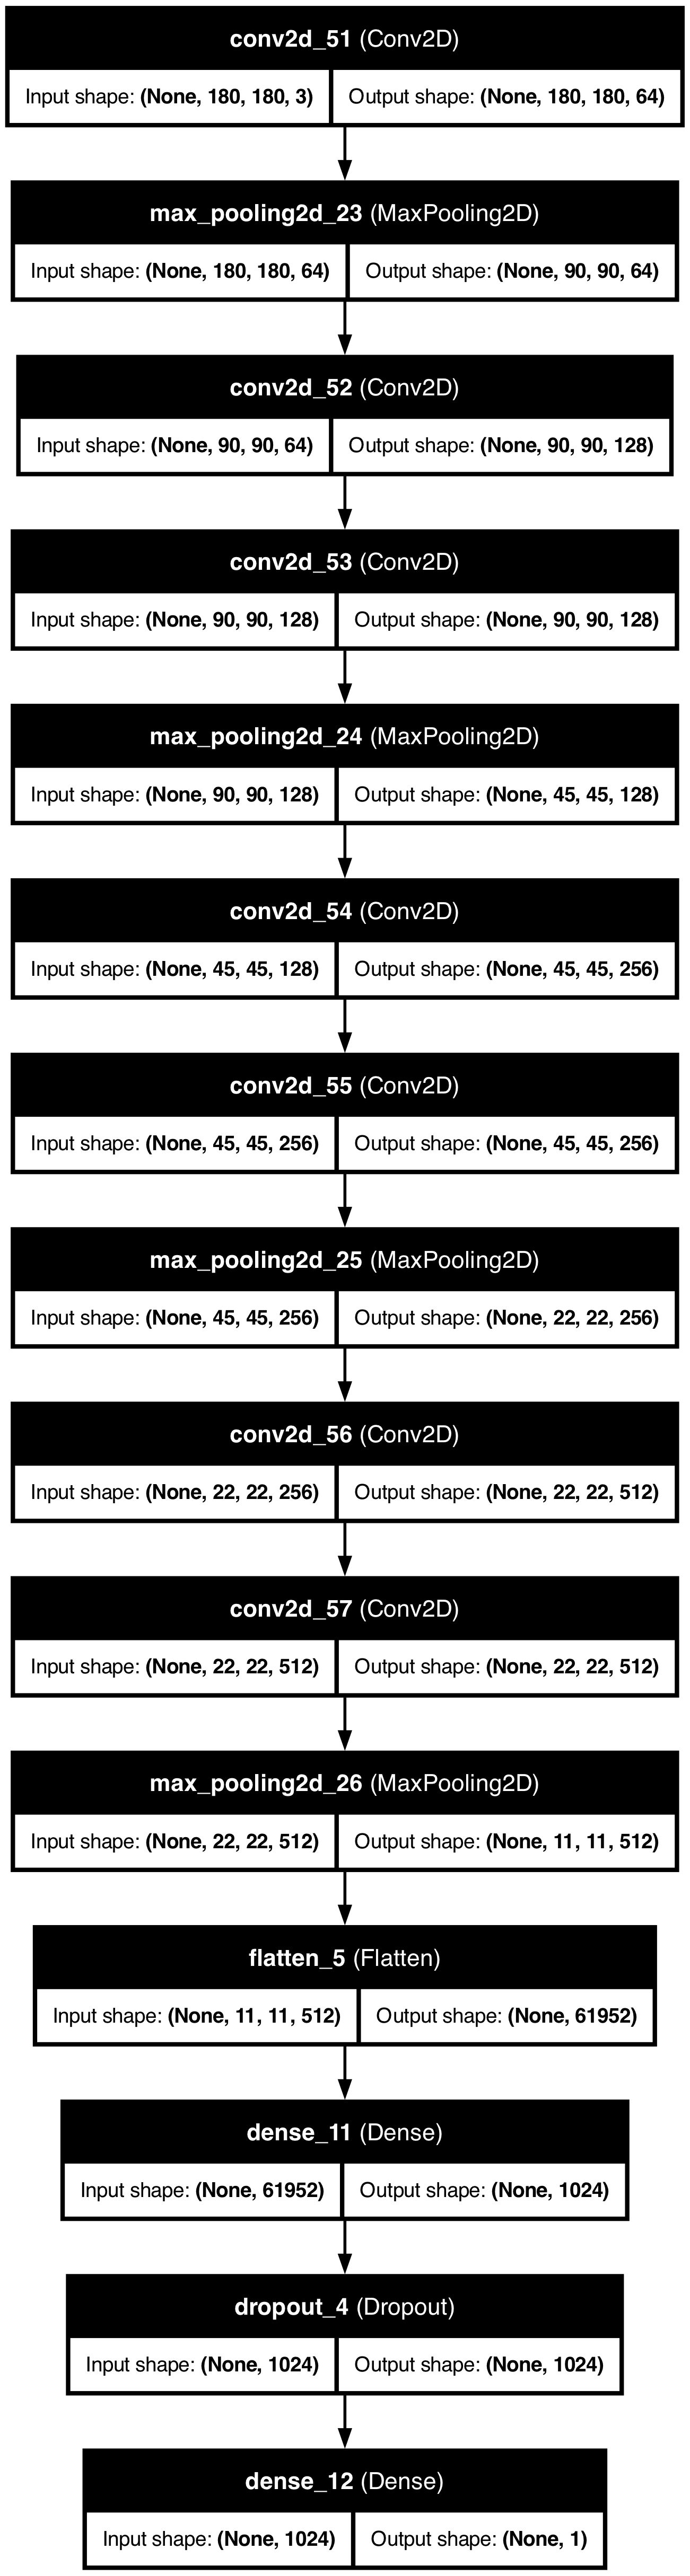

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename='model.png')

2025-04-25 12:16:24.381727: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


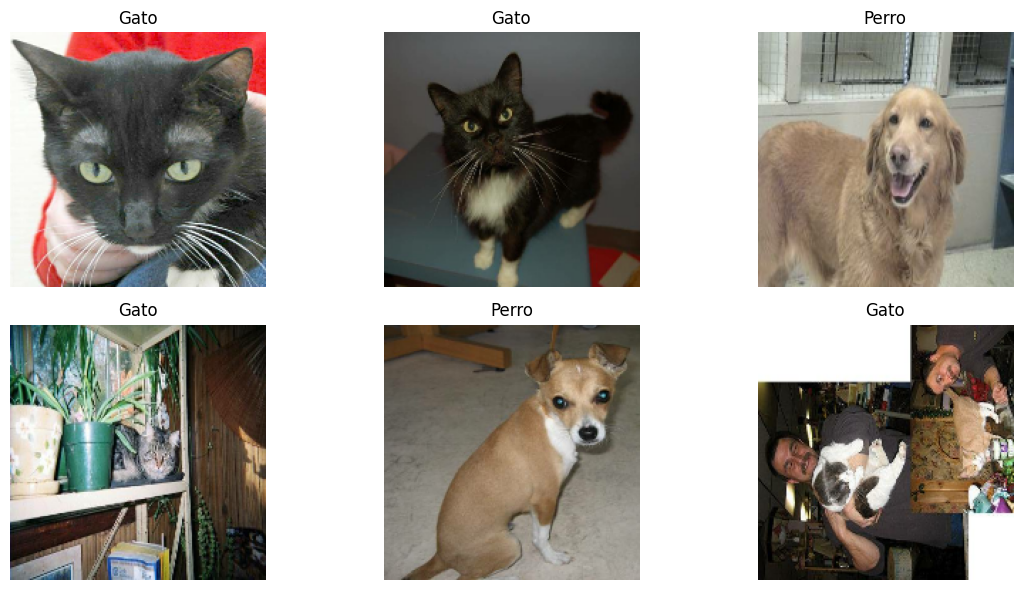

2025-04-25 12:16:24.834746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [50]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].numpy()
        # Escala si es necesario
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")
        else:
            img = img.astype("uint8")
        plt.imshow(img)
        plt.title("Gato" if labels[i] == 0 else "Perro")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [52]:
import tensorflow as tf

print("Versión de TensorFlow:", tf.__version__)
print("Dispositivos físicos disponibles:")
print(tf.config.list_physical_devices())

print("¿Usando GPU?", tf.config.list_logical_devices('GPU'))

Versión de TensorFlow: 2.16.2
Dispositivos físicos disponibles:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
¿Usando GPU? [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [51]:
!pip install scipy

## **ENTRENAMIENTO DEL MODELO A-2 SELECCIONADO**

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

# Callbacks mejorados
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./checkpoints/best_model.keras",  # Guardar el modelo completo
        save_best_only=True,  # Guardar solo el mejor modelo basado en la validación
        monitor="val_loss",  # Monitorear la pérdida de validación
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Monitorear la pérdida de validación
        patience=20,  # Detener el entrenamiento si no hay mejora durante 50 épocas
        restore_best_weights=True,  # Restaurar los mejores pesos
        verbose=1
    )
]

# Callback personalizado para guardar precisión por batch
class BatchAccuracyCallback(keras.callbacks.Callback):
    def __init__(self):
        self.batch_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        if logs is not None:
            self.batch_accuracies.append(logs.get('accuracy'))

# Crear una instancia del callback
batch_acc_callback = BatchAccuracyCallback()

history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=test_dataset,
    callbacks=callbacks + [batch_acc_callback]
)


Epoch 1/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4783 - loss: 0.6997
Epoch 1: val_loss improved from inf to 0.69320, saving model to ./checkpoints/best_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 143s 528ms/step - accuracy: 0.4783 - loss: 0.6997 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.4838 - loss: 0.6934
Epoch 2: val_loss improved from 0.69320 to 0.69317, saving model to ./checkpoints/best_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 196s 743ms/step - accuracy: 0.4838 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/60
 79/263 ━━━━━━━━━━━━━━━━━━━━ 2:29 813ms/step - accuracy: 0.4723 - loss: 0.6933

KeyboardInterrupt: 

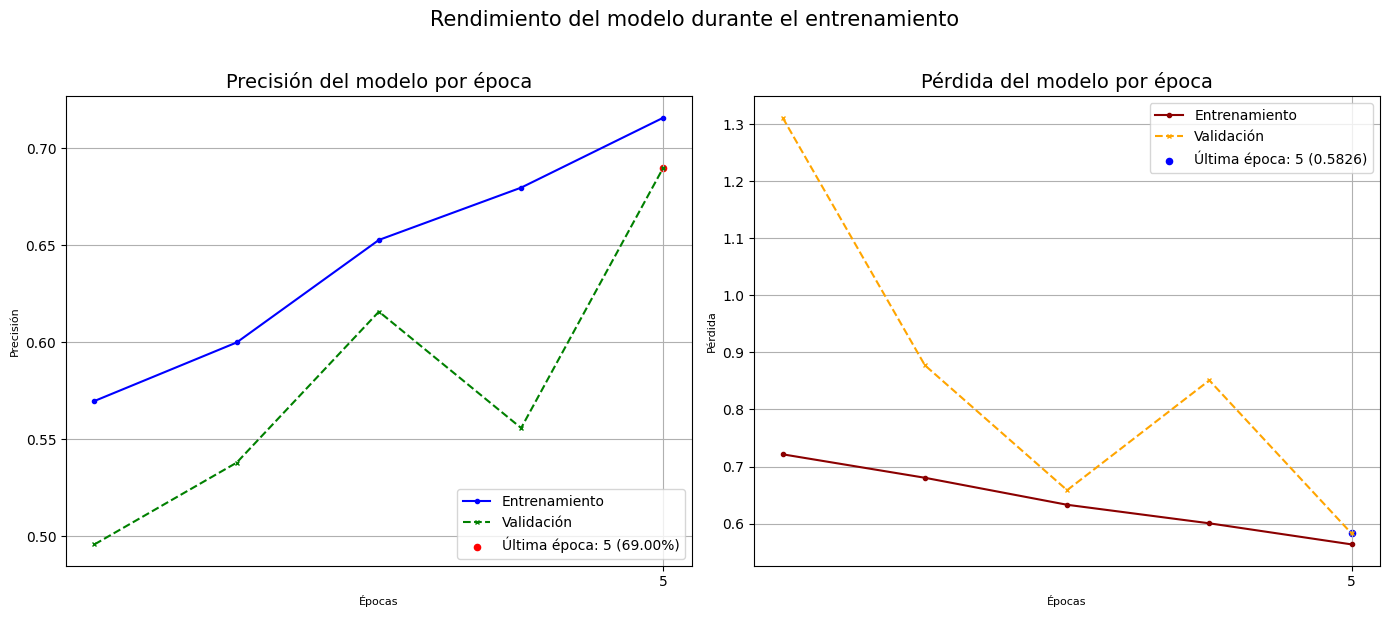

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Asumimos que history_dict contiene las métricas del entrenamiento
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)  # Esto ajusta las épocas según el tamaño de los datos disponibles

# Crear figura
plt.figure(figsize=(14, 6))

# =============================
# Gráfico de Precisión
# =============================
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['accuracy'], label='Entrenamiento', color='blue', linestyle='-', marker='o', markersize=3)
plt.plot(epochs, history_dict['val_accuracy'], label='Validación', color='green', linestyle='--', marker='x', markersize=3)

# Marcar el último punto de validación
last_epoch = epochs[-1]  # Última época
last_val_acc = history_dict['val_accuracy'][-1]  # Última precisión de validación
plt.scatter(last_epoch, last_val_acc, color='red', s=20, label=f'Última época: {last_epoch} ({last_val_acc:.2%})')

plt.title('Precisión del modelo por época', fontsize=14)
plt.xlabel('Épocas', fontsize=8)
plt.ylabel('Precisión', fontsize=8)
plt.xticks([last_epoch])  # Solo mostrar la última época en el eje X
plt.grid(True)
plt.legend(loc='lower right')

# =============================
# Gráfico de Pérdida
# =============================
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['loss'], label='Entrenamiento', color='darkred', linestyle='-', marker='o', markersize=3)
plt.plot(epochs, history_dict['val_loss'], label='Validación', color='orange', linestyle='--', marker='x', markersize=3)

# Marcar el último punto de validación (última pérdida)
last_loss = history_dict['val_loss'][-1]  # Última pérdida de validación
plt.scatter(last_epoch, last_loss, color='blue', s=20, label=f'Última época: {last_epoch} ({last_loss:.4f})')

plt.title('Pérdida del modelo por época', fontsize=14)
plt.xlabel('Épocas', fontsize=8)
plt.ylabel('Pérdida', fontsize=8)
plt.xticks([last_epoch])  # Solo mostrar la última época en el eje X
plt.grid(True)
plt.legend(loc='upper right')

# Ajustes finales
plt.suptitle('Rendimiento del modelo durante el entrenamiento', fontsize=15, y=1.02)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

En la figura se observa que la precisión en el conjunto de entrenamiento continúa aumentando de forma sostenida, mientras que la precisión en validación alcanza un valor asintótico a partir de la época 160–170 y comienza a fluctuar. De forma similar, la pérdida de validación deja de disminuir en ese mismo intervalo y muestra un leve repunte hacia el final.
Este comportamiento es indicativo de sobreajuste, ya que el modelo sigue optimizando el rendimiento sobre los datos vistos, pero pierde capacidad para generalizar sobre ejemplos no vistos.

Este comportamiento sugiere que el modelo ha comenzado a memorizar las características específicas del conjunto de entrenamiento, en lugar de aprender representaciones generalizables. Como resultado, su capacidad de generalización a datos nuevos (reflejados en el conjunto de validación) se ve comprometida, lo que confirma la presencia de sobreajuste.

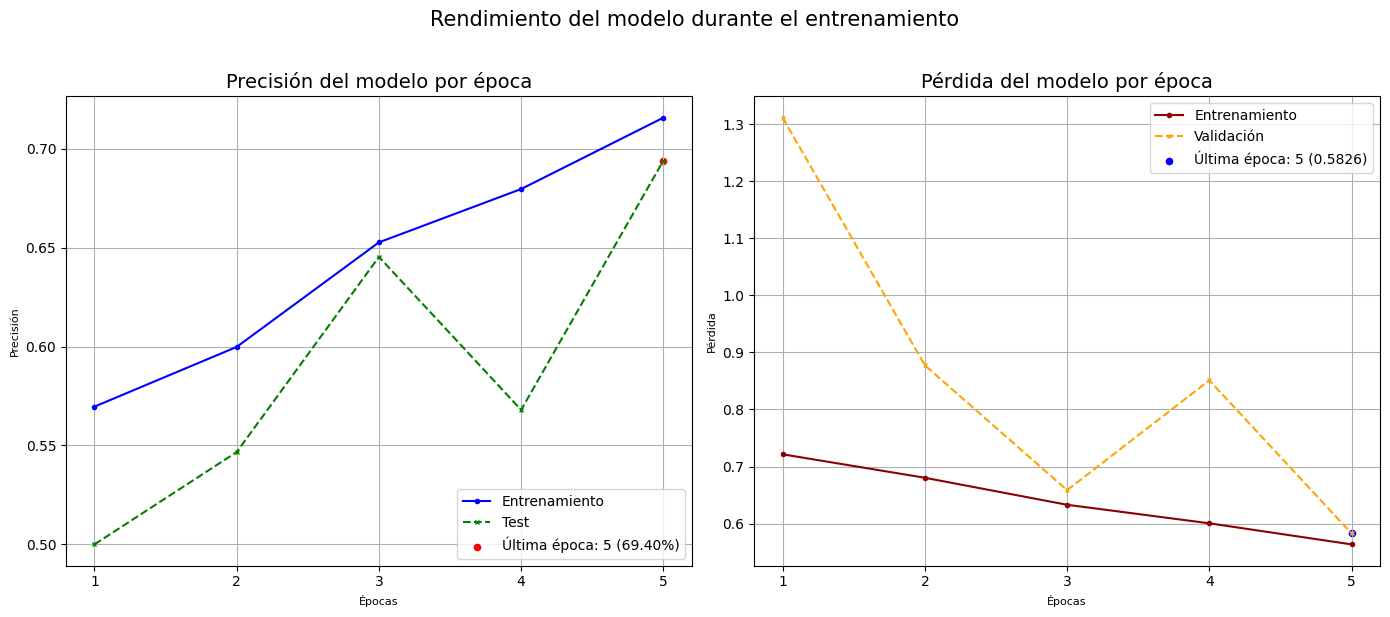

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Asumimos que history_dict contiene las métricas del entrenamiento
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)  # Esto ajusta las épocas según el tamaño de los datos disponibles

# Crear figura
plt.figure(figsize=(14, 6))

# =============================
# Gráfico de Precisión
# =============================
plt.subplot(1, 2, 1)
# Precisión de entrenamiento por época
plt.plot(epochs, history_dict['accuracy'], label='Entrenamiento', color='blue', linestyle='-', marker='o', markersize=3)

# Precisión de test por época desde tu callback personalizado
plt.plot(epochs, test_acc_callback.test_accuracies, label='Test', color='green', linestyle='--', marker='x', markersize=3)

# Marcar el último punto de test
last_epoch = epochs[-1]  # Última época
last_test_acc = test_acc_callback.test_accuracies[-1]  # Última precisión de test
plt.scatter(last_epoch, last_test_acc, color='red', s=20, label=f'Última época: {last_epoch} ({last_test_acc:.2%})')

plt.title('Precisión del modelo por época', fontsize=14)
plt.xlabel('Épocas', fontsize=8)
plt.ylabel('Precisión', fontsize=8)
plt.xticks(epochs)  # Mostrar todas las épocas en el eje X
plt.grid(True)
plt.legend(loc='lower right')

# =============================
# Gráfico de Pérdida
# =============================
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['loss'], label='Entrenamiento', color='darkred', linestyle='-', marker='o', markersize=3)
plt.plot(epochs, history_dict['val_loss'], label='Validación', color='orange', linestyle='--', marker='x', markersize=3)

# Marcar el último punto de validación (última pérdida)
last_loss = history_dict['val_loss'][-1]
plt.scatter(last_epoch, last_loss, color='blue', s=20, label=f'Última época: {last_epoch} ({last_loss:.4f})')

plt.title('Pérdida del modelo por época', fontsize=14)
plt.xlabel('Épocas', fontsize=8)
plt.ylabel('Pérdida', fontsize=8)
plt.xticks(epochs)
plt.grid(True)
plt.legend(loc='upper right')

# Ajustes finales
plt.suptitle('Rendimiento del modelo durante el entrenamiento', fontsize=15, y=1.02)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

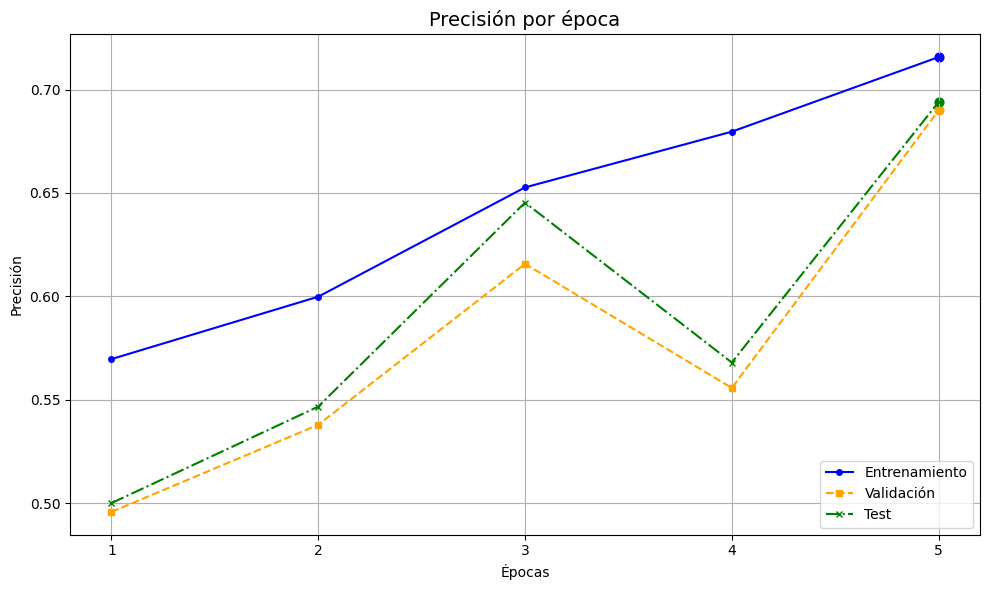

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Recuperamos la historia del entrenamiento
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

# Crear figura
plt.figure(figsize=(10, 6))

# =============================
# Gráfico de Precisión
# =============================
plt.plot(epochs, history_dict['accuracy'], label='Entrenamiento', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(epochs, history_dict['val_accuracy'], label='Validación', color='orange', linestyle='--', marker='s', markersize=4)
plt.plot(epochs, test_acc_callback.test_accuracies, label='Test', color='green', linestyle='-.', marker='x', markersize=4)

# Últimos valores
last_epoch = epochs[-1]
plt.scatter(last_epoch, history_dict['accuracy'][-1], color='blue', s=40)
plt.scatter(last_epoch, history_dict['val_accuracy'][-1], color='orange', s=40)
plt.scatter(last_epoch, test_acc_callback.test_accuracies[-1], color='green', s=40)

# Etiquetas y estilo
plt.title('Precisión por época', fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Precisión', fontsize=10)
plt.xticks(epochs)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()

# Mostrar
plt.show()

### Graficamos el conjunto de entrenamiento, por batch / época

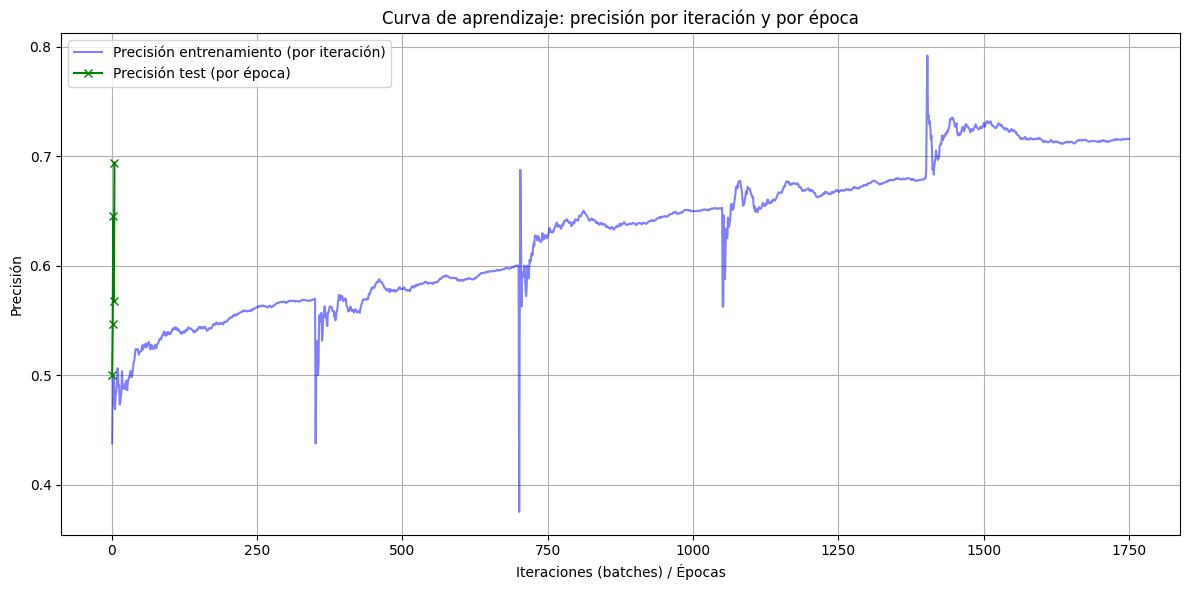

In [75]:
import matplotlib.pyplot as plt

# Rango de iteraciones (batches) y épocas
batches = range(1, len(batch_acc_callback.batch_accuracies) + 1)
epochs = range(1, len(test_acc_callback.test_accuracies) + 1)

# Crear figura
plt.figure(figsize=(12, 6))

# Precisión de entrenamiento por batch (iteración)
plt.plot(batches, batch_acc_callback.batch_accuracies, label='Precisión entrenamiento (por iteración)', color='blue', alpha=0.5)

# Precisión de test por época
plt.plot(epochs, test_acc_callback.test_accuracies, label='Precisión test (por época)', color='green', marker='x')

# Estética
plt.title('Curva de aprendizaje: precisión por iteración y por época')
plt.xlabel('Iteraciones (batches) / Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar gráfico
plt.show()

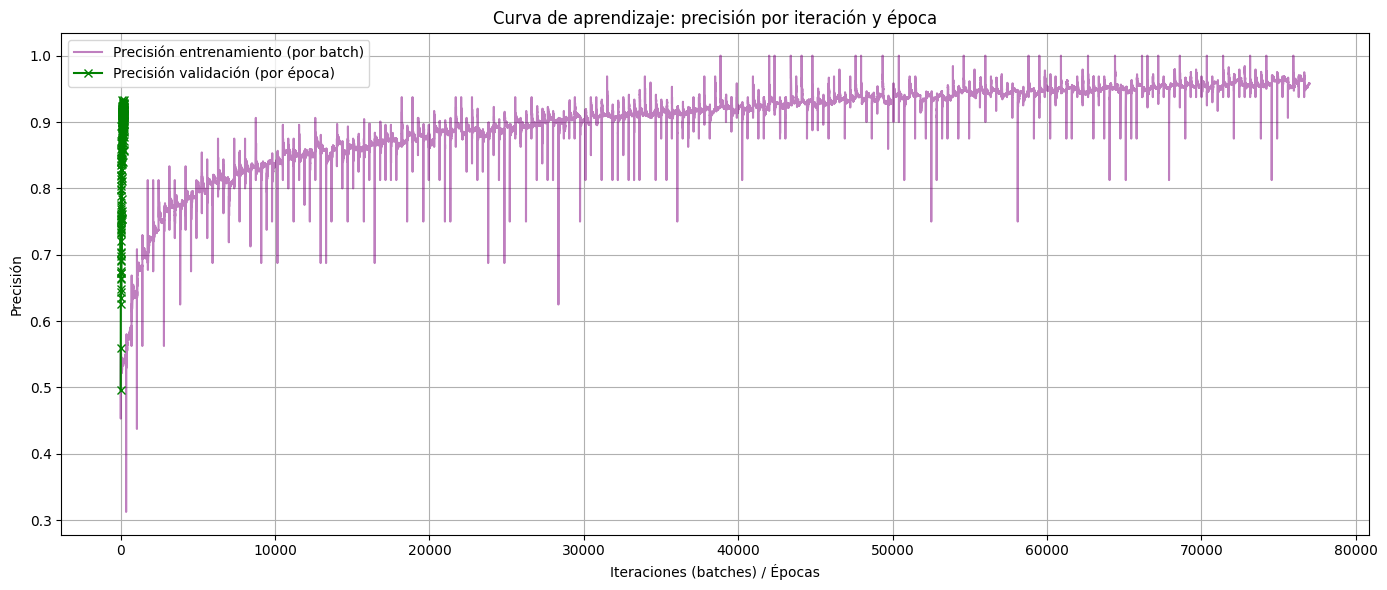

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)
batches = range(1, len(batch_acc_callback.batch_accuracies) + 1)

plt.figure(figsize=(14, 6))

# Precisión por batch (entrenamiento)
plt.plot(batches, batch_acc_callback.batch_accuracies, label='Precisión entrenamiento (por batch)', color='purple', alpha=0.5)

# Precisión por época (validación)
plt.plot(epochs, history.history['val_accuracy'], label='Precisión validación (por época)', color='green', marker='x')

plt.xlabel('Iteraciones (batches) / Épocas')
plt.ylabel('Precisión')
plt.title('Curva de aprendizaje: precisión por iteración y época')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

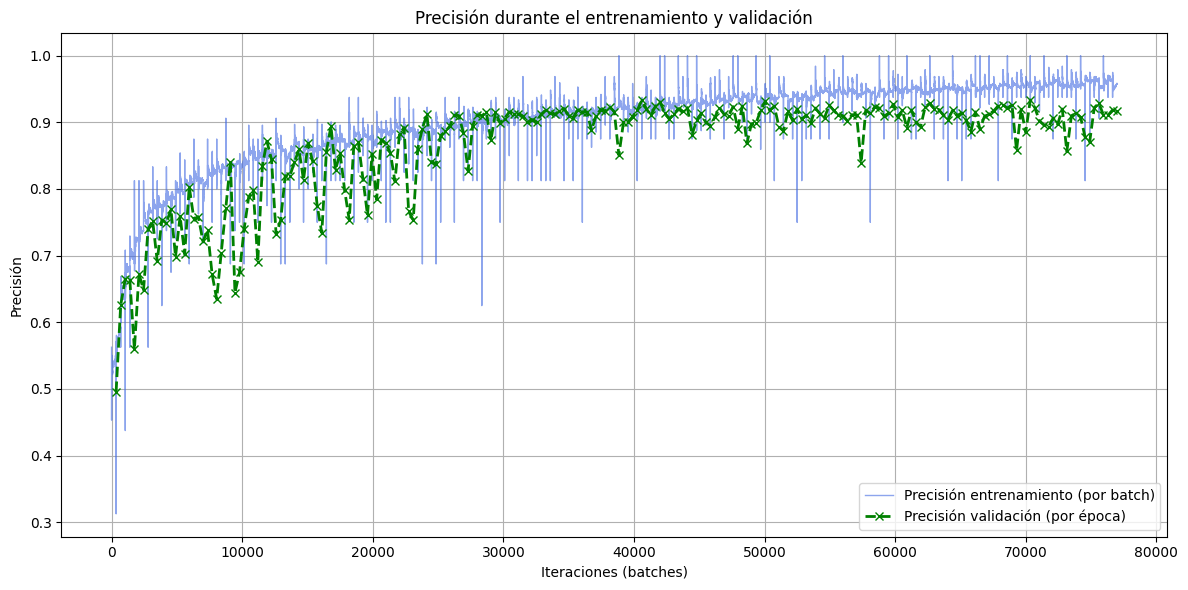

In [70]:
import matplotlib.pyplot as plt

# Eje X para batches (iteraciones de entrenamiento)
batches = range(1, len(batch_acc_callback.batch_accuracies) + 1)

# Eje X para épocas (para validación)
epochs = range(1, len(history.history['val_accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Precisión por batch (entrenamiento)
plt.plot(batches, batch_acc_callback.batch_accuracies,
         label='Precisión entrenamiento (por batch)',
         color='royalblue', linewidth=1, alpha=0.6)

# Precisión por época (validación)
plt.plot([i * len(train_dataset) for i in epochs],  # convertir épocas a "posición" en el eje de batches
         history.history['val_accuracy'],
         label='Precisión validación (por época)',
         color='green', marker='x', linestyle='--', linewidth=2)

# Estética
plt.title('Precisión durante el entrenamiento y validación')
plt.xlabel('Iteraciones (batches)')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
test_model = keras.models.load_model("./checkpoints/best_model.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9423 - loss: 0.1709
Test accuracy: 0.931


## **Detección de sobreajuste(s)**

#### **Criterio para detectar sobreajuste**
Se considera que hay sobreajuste (*overfitting*) cuando:
1. La precisión en validación (`val_accuracy`) deja de mejorar o incluso empeora,
2. Mientras que la precisión en entrenamiento sigue subiendo,
3. O cuando la pérdida en validación (`val_loss`) empieza a aumentar mientras la de entrenamiento sigue bajando.

In [30]:
import numpy as np

# Encuentra la época con la mejor val_loss (mínima)
best_epoch = np.argmin(history.history['val_loss'])
print(f"La mejor época (menor val_loss) es la {best_epoch}")

# Opcional: muestra la val_loss antes y después para ver tendencia
print("val_loss en las primeras épocas:", history.history['val_loss'][:best_epoch+3])

La mejor época (menor val_loss) es la 119
val_loss en las primeras épocas: [1.273983120918274, 0.6368432641029358, 0.6083853840827942, 0.61184161901474, 0.9301801323890686, 0.6168100237846375, 0.6991070508956909, 0.5415565967559814, 0.5306819677352905, 0.6907526850700378, 0.5104487538337708, 0.5420987606048584, 0.4862942099571228, 0.6530888676643372, 0.5299078226089478, 0.6371691226959229, 0.44595956802368164, 0.511064887046814, 0.5665792226791382, 0.6850390434265137, 0.5682164430618286, 0.8516376614570618, 1.0511342287063599, 0.6366661190986633, 0.5223117470741272, 0.3637731969356537, 0.8305487036705017, 0.8177103996276855, 0.6013136506080627, 0.46794992685317993, 0.465560644865036, 0.6540404558181763, 0.36390015482902527, 0.3189603388309479, 0.3688867688179016, 0.60255366563797, 0.5339577794075012, 0.41820648312568665, 0.42295166850090027, 0.3661947250366211, 0.32307907938957214, 0.41816821694374084, 0.3222162425518036, 0.38362759351730347, 0.5413716435432434, 0.599441409111023, 0.33

In [67]:
import pandas as pd

def resumen_val_accuracy(history):
    # Convertir history a DataFrame
    df = pd.DataFrame(history.history)
    df['epoch'] = df.index + 1  # Añadir número de época

    # Verifica si 'val_accuracy' está presente
    if 'val_accuracy' not in df.columns:
        print("No se encontró 'val_accuracy' en el objeto history.")
        print(f"Columnas disponibles: {list(df.columns)}")
        return

    # Seleccionar las 6 mejores épocas
    top6 = df.nlargest(6, 'val_accuracy')[['epoch', 'val_accuracy', 'accuracy']]

    # Seleccionar las 6 últimas épocas
    last6 = df.tail(6)[['epoch', 'val_accuracy', 'accuracy']]

    # Mostrar resultados
    print("Las 6 épocas con mejor validación (val_accuracy):")
    print(top6.to_string(index=False))

    print("\Las últimas 6 épocas:")
    print(last6.to_string(index=False))

resumen_val_accuracy(history)

Las 6 épocas con mejor validación (val_accuracy):
 epoch  val_accuracy  accuracy
   201      0.933571  0.953929
   116      0.932857  0.922857
   143      0.931429  0.934464
   120      0.930714  0.926429
   179      0.928571  0.946250
   216      0.928571  0.962321
\Las últimas 6 épocas:
 epoch  val_accuracy  accuracy
   215      0.922143  0.963214
   216      0.928571  0.962321
   217      0.911429  0.954107
   218      0.910714  0.960536
   219      0.918571  0.960714
   220      0.917143  0.957857


Como se puede observar en:
```
epoch  val_accuracy  accuracy
   201      0.933571  0.953929
   116      0.932857  0.922857
   143      0.931429  0.934464
   120      0.930714  0.926429
   179      0.928571  0.946250
   216      0.928571  0.962321
\Las últimas 6 épocas:
 epoch  val_accuracy  accuracy
   215      0.922143  0.963214
   216      0.928571  0.962321
   217      0.911429  0.954107
   218      0.910714  0.960536
   219      0.918571  0.960714
   220      0.917143  0.957857
```
Sí que existe cierto índice de un posible sobreajuste, pues ya en la e´poca 116 o 120 encontramos 1 de los 6 mejores val accuracy, que luego en las últimas 6 épocas disminuye, mientras que el accuracy aumenta.

In [68]:
def detectar_sobreajuste_suave(history, min_ep=3, tolerancia=2):
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    mejor_val_loss = float('inf')
    ep_sin_mejora = 0

    for i in range(min_ep, len(val_loss)):
        if val_loss[i] < mejor_val_loss:
            mejor_val_loss = val_loss[i]
            ep_sin_mejora = 0  # Resetea si mejora
        else:
            ep_sin_mejora += 1

        if ep_sin_mejora >= tolerancia:
            return i - tolerancia + 1  # Devuelve la época en la que dejó de mejorar

    return None

epoca_sobreajuste = detectar_sobreajuste_suave(history, min_ep=10, tolerancia=5)

if epoca_sobreajuste:
    print(f"Se detecta inicio de sobreajuste en la época {epoca_sobreajuste}")
else:
    print("No se detecta sobreajuste claro")

Se detecta inicio de sobreajuste en la época 17


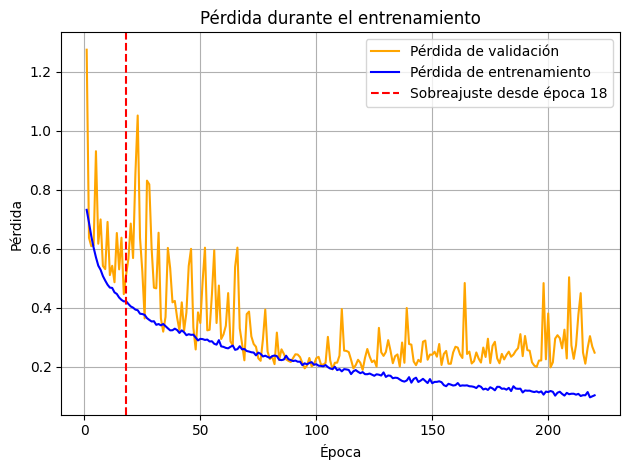

In [32]:
# Detectar sobreajuste (con criterio tolerante)
best_epoch = detectar_sobreajuste_suave(history, min_ep=10, tolerancia=5)

# Graficar la pérdida de validación y marcar el inicio del sobreajuste
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['val_loss'], label='Pérdida de validación', color='orange')
plt.plot(epochs, history.history['loss'], label='Pérdida de entrenamiento', color='blue')

if best_epoch:
    plt.axvline(x=best_epoch + 1, color='red', linestyle='--', label=f'Sobreajuste desde época {best_epoch + 1}')

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Una forma básica de "detectar" sobreajuste sin gráfica es comparar la diferencia entre la pérdida (o accuracy) de entrenamiento y validación:

In [33]:
# Últimos valores de pérdida y accuracy
final_train_loss = history.history["loss"][-1]
final_val_loss = history.history["val_loss"][-1]

final_train_acc = history.history["accuracy"][-1]
final_val_acc = history.history["val_accuracy"][-1]

# Heurística de sobreajuste
loss_gap = final_val_loss - final_train_loss
acc_gap = final_train_acc - final_val_acc

print(f"Diferencia de pérdida: {loss_gap:.4f}")
print(f"Diferencia de accuracy: {acc_gap:.4f}")

if loss_gap > 0.5 and acc_gap > 0.1:
    print("Posible sobreajuste detectado.")
else:
    print("No hay signos claros de sobreajuste.")

Diferencia de pérdida: 0.1445
Diferencia de accuracy: 0.0407
No hay signos claros de sobreajuste.


Slope Analysis (tendencia de val_loss)
Otra opción es detectar si val_loss está aumentando consistentemente mientras train_loss disminuye, con una regresión lineal sobre las últimas n épocas:

In [34]:
import numpy as np
from scipy.stats import linregress

def compute_val_loss_trend(history, window=5):
    val_losses = history.history["val_loss"][-window:]
    epochs = np.arange(len(val_losses))
    slope, _, _, _, _ = linregress(epochs, val_losses)
    return slope

slope = compute_val_loss_trend(history)
if slope > 0:
    print(f"Tendencia creciente de val_loss detectada (slope = {slope:.4f}).")
else:
    print(f"Sin tendencia clara de aumento de val_loss (slope = {slope:.4f})")

Tendencia creciente de val_loss detectada (slope = 0.0079).


Generalization Gap (como métrica formal)
Se puede definir un “gap de generalización” entre entrenamiento y validación. Esto se puede usar como métrica objetiva:

In [35]:
def generalization_gap(train_acc, val_acc):
    return abs(train_acc - val_acc)

gap = generalization_gap(final_train_acc, final_val_acc)
print(f"Generalization Gap: {gap:.4f}")

if gap > 0.1:
    print("Gap elevado → indicio de sobreajuste.")
else:
    print("Gap NO indica, descriptivamente, posible sobreajuste.")

Generalization Gap: 0.0407
Gap NO indica, descriptivamente, posible sobreajuste.


In [1]:
import matplotlib.pyplot as plt

# Extraer métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Graficar precisión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por Época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Graficar pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

## **Visualizar los mapas de activación**

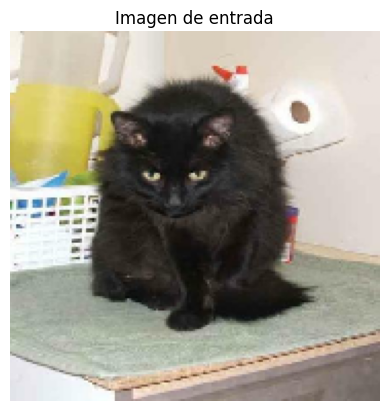

/opt/anaconda3/envs/keras_env/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


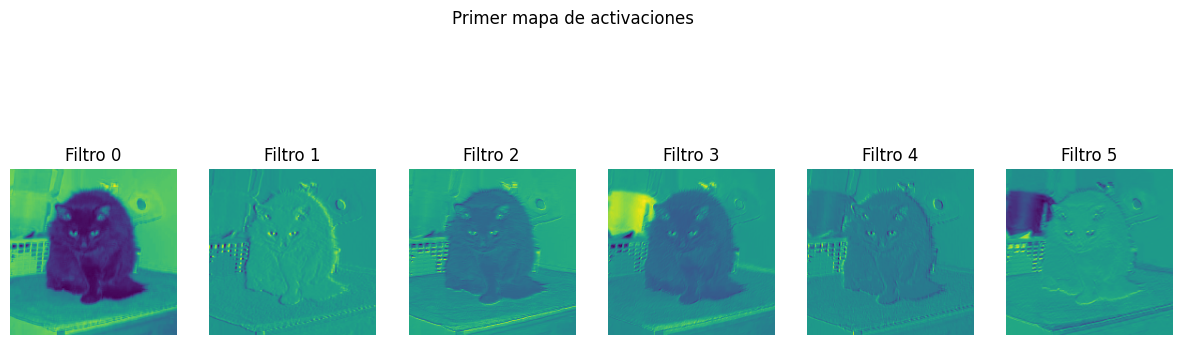

In [80]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Ruta a una imagen de entrenamiento
img_dir = "cats_vs_dogs/train2/cats"
img_name = os.listdir(img_dir)[0]  # Tomamos la primera imagen disponible
img_path = os.path.join(img_dir, img_name)

# Cargar y procesar imagen
img = image.load_img(img_path, target_size=(180, 180))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Mostrar imagen
plt.imshow(img_array[0])
plt.title("Imagen de entrada")
plt.axis("off")
plt.show()

# Activaciones
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name][:3]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

# Mostrar activaciones de la primera capa
first_layer_activation = activations[0]
num_filters = min(6, first_layer_activation.shape[-1])

plt.figure(figsize=(15, 5))
for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.title(f"Filtro {i}")
    plt.axis("off")
plt.suptitle("Primer mapa de activaciones")
plt.show()

### Visualizar núcleos

Shape de filtros: (3, 3, 3, 32)
Shape de biases: (32,)


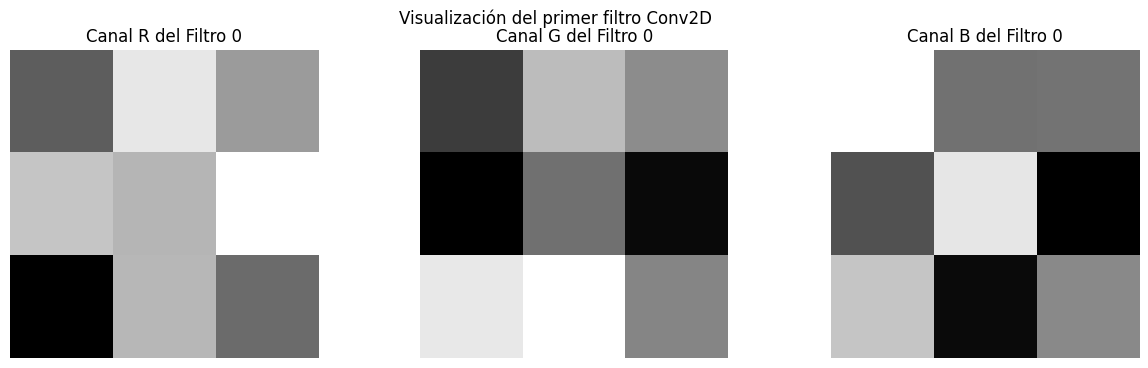

Pesos de la primera capa: [array([[[[ 7.30985659e-04, -1.49057508e-01,  6.79191900e-03,
           1.18643411e-01,  5.61255962e-02, -6.72713667e-02,
          -9.08635333e-02,  1.05013095e-01,  4.95765321e-02,
          -1.38659805e-01, -1.15317419e-01, -3.58255543e-02,
          -8.91747996e-02,  1.09368265e-01,  2.86514238e-02,
          -1.20552912e-01, -2.47483072e-03,  1.04116492e-01,
          -1.11309566e-01, -4.94467020e-02, -8.42530504e-02,
          -1.33696455e-03,  7.04803690e-02, -4.90435399e-02,
          -5.04969526e-03, -1.08876653e-01, -4.60802503e-02,
          -1.17860787e-01,  8.67678225e-02, -9.90011990e-02,
          -1.37198702e-01,  9.43074897e-02],
         [-7.44749978e-02,  3.01949936e-03, -1.28633663e-01,
          -1.02707580e-01, -5.96417487e-02,  5.23443855e-02,
           1.32682174e-01,  1.06451117e-01,  1.16898395e-01,
          -4.10304777e-02,  1.24651760e-01,  5.92832780e-03,
          -6.56129932e-03,  8.49976242e-02,  9.88521650e-02,
           1.

In [81]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Encontrar la primera capa Conv2D del modelo
first_conv_layer = next((layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)), None)

# Acceder a los pesos del primer Conv2D
if first_conv_layer is not None:
    filters, biases = first_conv_layer.get_weights()
    print("Shape de filtros:", filters.shape)  # Ej: (3, 3, 3, 32)
    print("Shape de biases:", biases.shape)    # Ej: (32,)

    # Visualizar el primer filtro (para los canales R, G, B)
    filtro_0 = filters[:, :, :, 0]

    plt.figure(figsize=(15, 4))
    for i in range(3):  # R, G, B
        plt.subplot(1, 3, i + 1)
        plt.imshow(filtro_0[:, :, i], cmap='gray')
        plt.title(f"Canal {['R', 'G', 'B'][i]} del Filtro 0")
        plt.axis("off")
    plt.suptitle("Visualización del primer filtro Conv2D")
    plt.show()
else:
    print("No se encontró una capa Conv2D en el modelo.")

print("Pesos de la primera capa:", first_conv_layer.get_weights())

### 

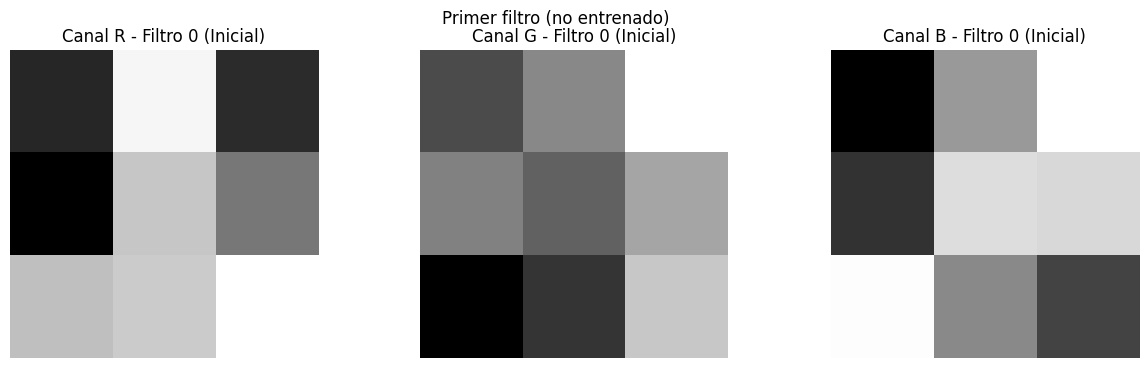

In [38]:
# Re-crear el modelo sin entrenar (con pesos aleatorios)
model_untrained = tf.keras.models.clone_model(model)
model_untrained.build((None, 180, 180, 3))  # Ajusta al tamaño de entrada si es diferente

# Obtener la primera capa Conv2D
first_conv = next((layer for layer in model_untrained.layers if isinstance(layer, tf.keras.layers.Conv2D)), None)

# Mostrar el primer filtro (pesos iniciales)
filters_untrained, _ = first_conv.get_weights()
filtro0_untrained = filters_untrained[:, :, :, 0]

plt.figure(figsize=(15, 4))
for i in range(3):  # RGB
    plt.subplot(1, 3, i + 1)
    plt.imshow(filtro0_untrained[:, :, i], cmap='gray')
    plt.title(f"Canal {['R','G','B'][i]} - Filtro 0 (Inicial)")
    plt.axis("off")
plt.suptitle("Primer filtro (no entrenado)")
plt.show()

In [39]:
model.input_shape

(None, 180, 180, 3)

Imagen seleccionada: cats_vs_dogs/train2/dogs/dogs_7135cee39fd445e0bc0862c916473873.jpg


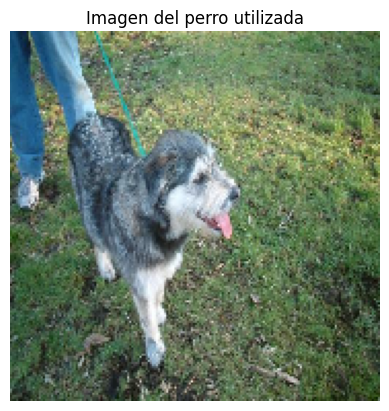

In [82]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd

# ==============================================
# Cargar datos
# ==============================================

def build_dataframe_from_folder(base_path):
    data = []
    for label in ["cats", "dogs"]:
        folder = os.path.join(base_path, label)
        for fname in os.listdir(folder):
            if fname.endswith(".jpg"):
                data.append({
                    "filename": os.path.join(folder, fname),
                    "category": 0 if label == "cats" else 1
                })
    return pd.DataFrame(data)

train_df = build_dataframe_from_folder("cats_vs_dogs/train2")

# ==============================================
# Seleccionar imagen de perro
# ==============================================

dog_image_path = train_df[train_df['category'] == 1].iloc[0]['filename']
print("Imagen seleccionada:", dog_image_path)

def load_and_preprocess_image(img_path, target_size=(180, 180)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img

img_input, img_display = load_and_preprocess_image(dog_image_path)

plt.imshow(img_display)
plt.title("Imagen del perro utilizada")
plt.axis("off")
plt.show()

# ==============================================
# Cargar modelo sin entrenar (para 4a)
# ==============================================

# Usa tu definición del modelo aquí:
model_untrained = tf.keras.models.clone_model(model)  # Asume que "model" ya está definido y entrenado
model_untrained.build(input_shape=(None, 180, 180, 3))

# ==============================================
# Cargar modelo entrenado (para 4b y 4c)
# ==============================================

model_trained = model  # Ya lo has entrenado previamente

# ==============================================
# Función auxiliar para visualizar activaciones
# ==============================================

def plot_activation_map(model, layer_index, image_input, title):
    activation_model = tf.keras.Model(inputs=model.input, outputs=model.layers[layer_index].output)
    activation = activation_model.predict(image_input)
    activation_map = activation[0, :, :, 0]  # Primer filtro

    plt.imshow(activation_map, cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_filter_kernels(layer, title_prefix=""):
    
    filters, biases = layer.get_weights()
    filtro_0 = filters[:, :, :, 0]  # Primer filtro
    plt.figure(figsize=(15, 4))
    for i in range(filtro_0.shape[-1]):  # Canal por canal
        plt.subplot(1, 3, i + 1)
        plt.imshow(filtro_0[:, :, i], cmap='gray')
        plt.title(f"{title_prefix} Canal {['R', 'G', 'B'][i]}")
        plt.axis("off")
    plt.suptitle(f"{title_prefix} - Núcleo del primer filtro")
    plt.show()

=== 4a. Núcleo y activación antes del entrenamiento ===


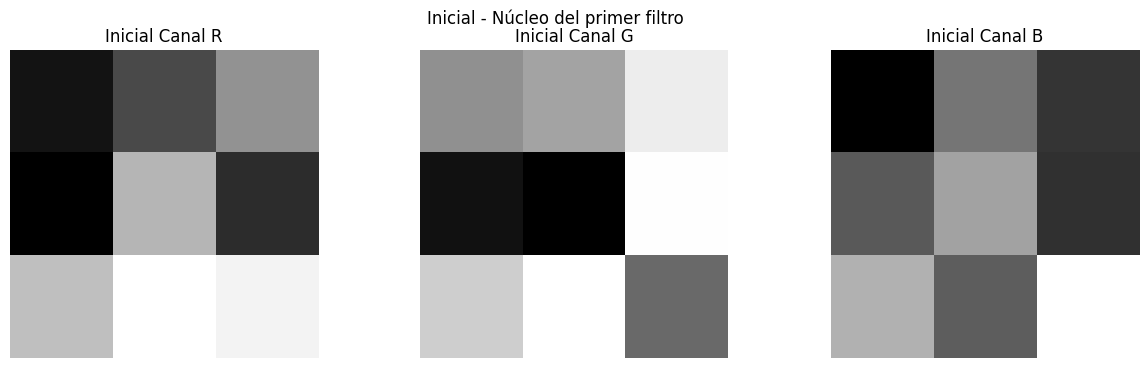

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


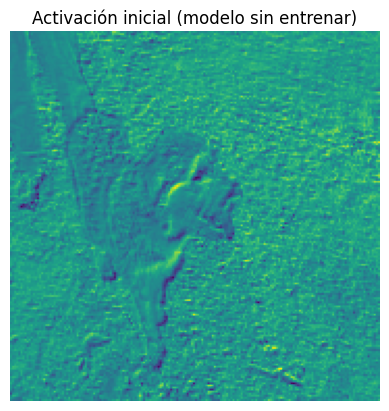

In [83]:
# ==============================================
# 4a. Filtro y activación inicial (modelo sin entrenar)
# ==============================================

print("=== 4a. Núcleo y activación antes del entrenamiento ===")

first_conv_untrained = next(l for l in model_untrained.layers if isinstance(l, tf.keras.layers.Conv2D))
plot_filter_kernels(first_conv_untrained, "Inicial")
plot_activation_map(model_untrained, model_untrained.layers.index(first_conv_untrained), img_input, title="Activación inicial (modelo sin entrenar)")

=== 4b. Núcleo y activación después del entrenamiento ===


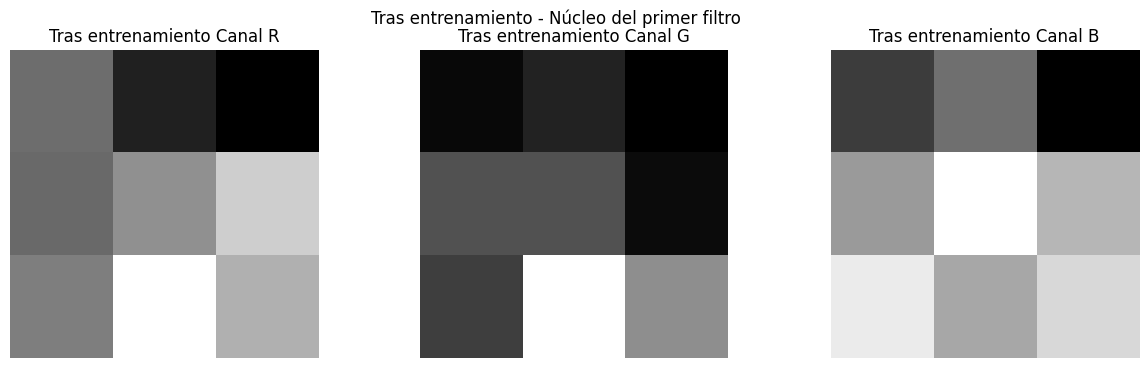

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


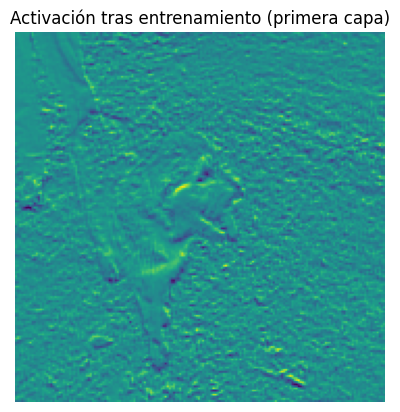

In [42]:
# ==============================================
# 4b. Filtro y activación después de entrenamiento (primera capa)
# ==============================================

print("=== 4b. Núcleo y activación después del entrenamiento ===")

first_conv_trained = next(l for l in model_trained.layers if isinstance(l, tf.keras.layers.Conv2D))
plot_filter_kernels(first_conv_trained, "Tras entrenamiento")
plot_activation_map(model_trained, model_trained.layers.index(first_conv_trained), img_input, title="Activación tras entrenamiento (primera capa)")

En un primer momento, establecí:
```
def plot_filter_kernels(layer, title_prefix=""):
    filters, biases = layer.get_weights()
    filtro_0 = filters[:, :, :, 0]  # Primer filtro
    plt.figure(figsize=(15, 4))
    for i in range(filtro_0.shape[-1]):  # Canal por canal
        plt.subplot(1, 3, i + 1)
        plt.imshow(filtro_0[:, :, i], cmap='gray')
        plt.title(f"{title_prefix} Canal {['R', 'G', 'B'][i]}")
        plt.axis("off")
    plt.suptitle(f"{title_prefix} - Núcleo del primer filtro")
    plt.show()
```
Sin embargo, no me dejaba visualizar el filtro (núcleo) de la última capa convolucional, para contestar a la pregunta 4c.
Además, así, también se puede adaptar la visualización al número real de canales del filtro. Por ende, si se aplica:
```
def plot_filter_kernels(layer, title_prefix="", max_channels=6):
    filters, biases = layer.get_weights()
    filtro_0 = filters[:, :, :, 0]  # Primer filtro (0)

    num_channels = filtro_0.shape[-1]
    num_to_show = min(num_channels, max_channels)

    plt.figure(figsize=(3 * num_to_show, 3))
    for i in range(num_to_show):
        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(filtro_0[:, :, i], cmap='gray')
        plt.title(f"Canal {i}")
        plt.axis("off")
    plt.suptitle(f"{title_prefix} - Núcleo del primer filtro", fontsize=14)
    plt.tight_layout()
    plt.show()
```
1. Ya no asume que tienes solo 3 canales como en **RGB**.
2. Se adapta dinámicamente a los canales del filtro de la última capa convolucional (que pueden ser decenas).
3. Muestra los primeros 6 canales por defecto (puedes cambiarlo con el argumento `max_channels`).

In [43]:
def plot_filter_kernels(layer, title_prefix="", max_channels=6):
    filters, biases = layer.get_weights()
    filtro_0 = filters[:, :, :, 0]  # Primer filtro (0)

    num_channels = filtro_0.shape[-1]
    num_to_show = min(num_channels, max_channels)

    plt.figure(figsize=(3 * num_to_show, 3))
    for i in range(num_to_show):
        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(filtro_0[:, :, i], cmap='gray')
        plt.title(f"Canal {i}")
        plt.axis("off")
    plt.suptitle(f"{title_prefix} - Núcleo del primer filtro", fontsize=14)
    plt.tight_layout()
    plt.show()

=== 4c. Activación de la última capa convolucional ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


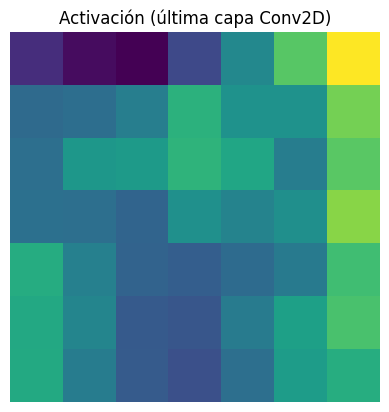

In [84]:
# ==============================================
# 4c. Activación del primer filtro en la última capa convolucional
# ==============================================

print("=== 4c. Activación de la última capa convolucional ===")

conv_indices = [i for i, l in enumerate(model_trained.layers) if isinstance(l, tf.keras.layers.Conv2D)]
last_conv_index = conv_indices[-1]
plot_activation_map(model_trained, last_conv_index, img_input, title="Activación (última capa Conv2D)")

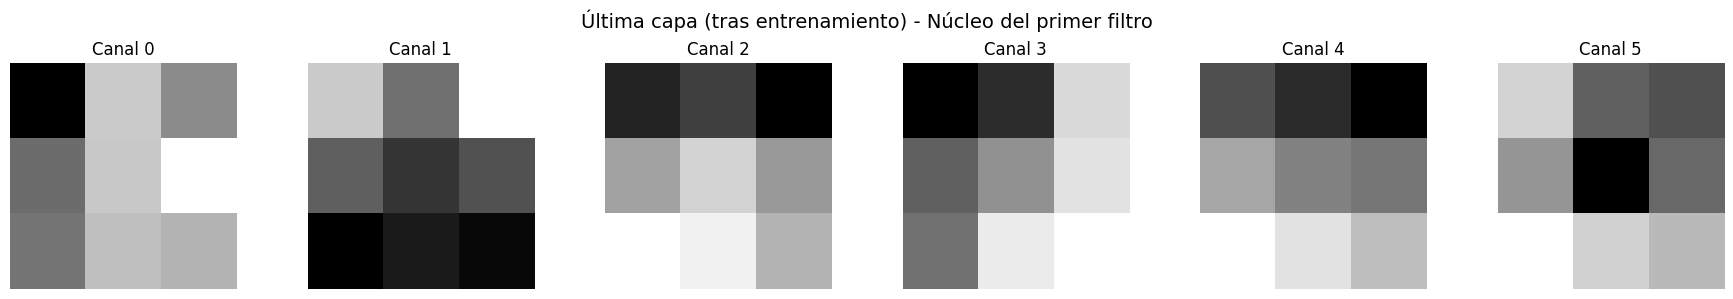

In [45]:
# 4c. Mostrar los filtros de la última capa convolucional
last_conv_layer = model_trained.layers[last_conv_index]
plot_filter_kernels(last_conv_layer, "Última capa (tras entrenamiento)")

En las visualizaciones de los núcleos de los filtros se han utilizado dos funciones distintas en función de la capa a analizar:
Para la primera capa convolucional (apartados 4a y 4b), se empleó una función específica que asume entrada RGB, y representa los canales como "R", "G" y "B". Esto mejora la interpretación visual del filtro, ya que en esa capa los canales corresponden directamente con los colores de entrada de la imagen.
Para la última capa convolucional (apartado 4c), se utilizó una función más general, que visualiza los primeros canales del núcleo como "Canal 0", "Canal 1", etc. Esto se debe a que, en capas profundas, los canales de entrada al filtro ya no representan colores, sino características latentes extraídas por las capas anteriores. Por ello, se considera más apropiada una visualización neutral y adaptable al número real de canales.
Además, es importante tener en cuenta que al clonar el modelo mediante tf.keras.models.clone_model(...) y volver a construirlo con .build(...), los pesos iniciales se generan aleatoriamente. Esto implica que los núcleos visualizados en el modelo sin entrenar pueden variar entre ejecuciones, aunque la estructura del modelo se mantenga idéntica.

### **Matriz de confusión**

2025-04-24 00:39:14.059746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


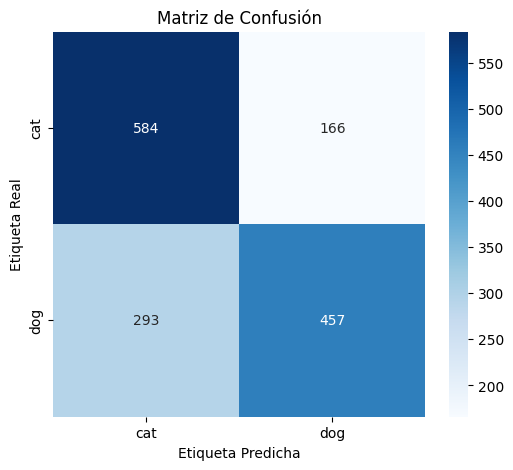

Gato clasificado como gato: 584
Gato clasificado como perro: 166
Perro clasificado como gato: 293
Perro clasificado como perro: 457


In [90]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_model = model

# Función para generar la matriz de confusión
def plot_confusion_matrix(model, test_dataset, class_names=["cat", "dog"]):
    y_true = []
    y_pred = []
    
    # Generar predicciones
    for images, labels in test_dataset:
        preds = model.predict(images, verbose=0)
        preds_binary = (preds > 0.5).astype(int).flatten()  # Binarias (0 o 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds_binary)

    # Convertir a arrays de NumPy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Graficar la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusión")
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.show()

    # Métricas adicionales
    tn, fp, fn, tp = cm.ravel()
    print(f"Gato clasificado como gato: {tn}")
    print(f"Gato clasificado como perro: {fp}")
    print(f"Perro clasificado como gato: {fn}")
    print(f"Perro clasificado como perro: {tp}")

# Mostrar la matriz de confusión
plot_confusion_matrix(test_model, test_dataset)

### **Ejemplos de clases predichas y la imagen real**

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def display_predictions(model, test_dataset, class_names=["cat", "dog"], num_images=6):
    images, labels = next(iter(test_dataset))

    # Predict
    preds = model.predict(images, verbose=0)
    preds_binary = (preds > 0.5).astype(int).flatten()

    # Convert to numpy
    images_np = images.numpy()
    labels_np = labels.numpy()

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images_np))):
        img = images_np[i].astype("uint8")
        true_label = class_names[int(labels_np[i].item())]
        pred_label = class_names[int(preds_binary[i].item())]
        title_color = "green" if true_label == pred_label else "red"

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {true_label}\nPred: {pred_label}", color=title_color, fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

/opt/anaconda3/envs/keras_env/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


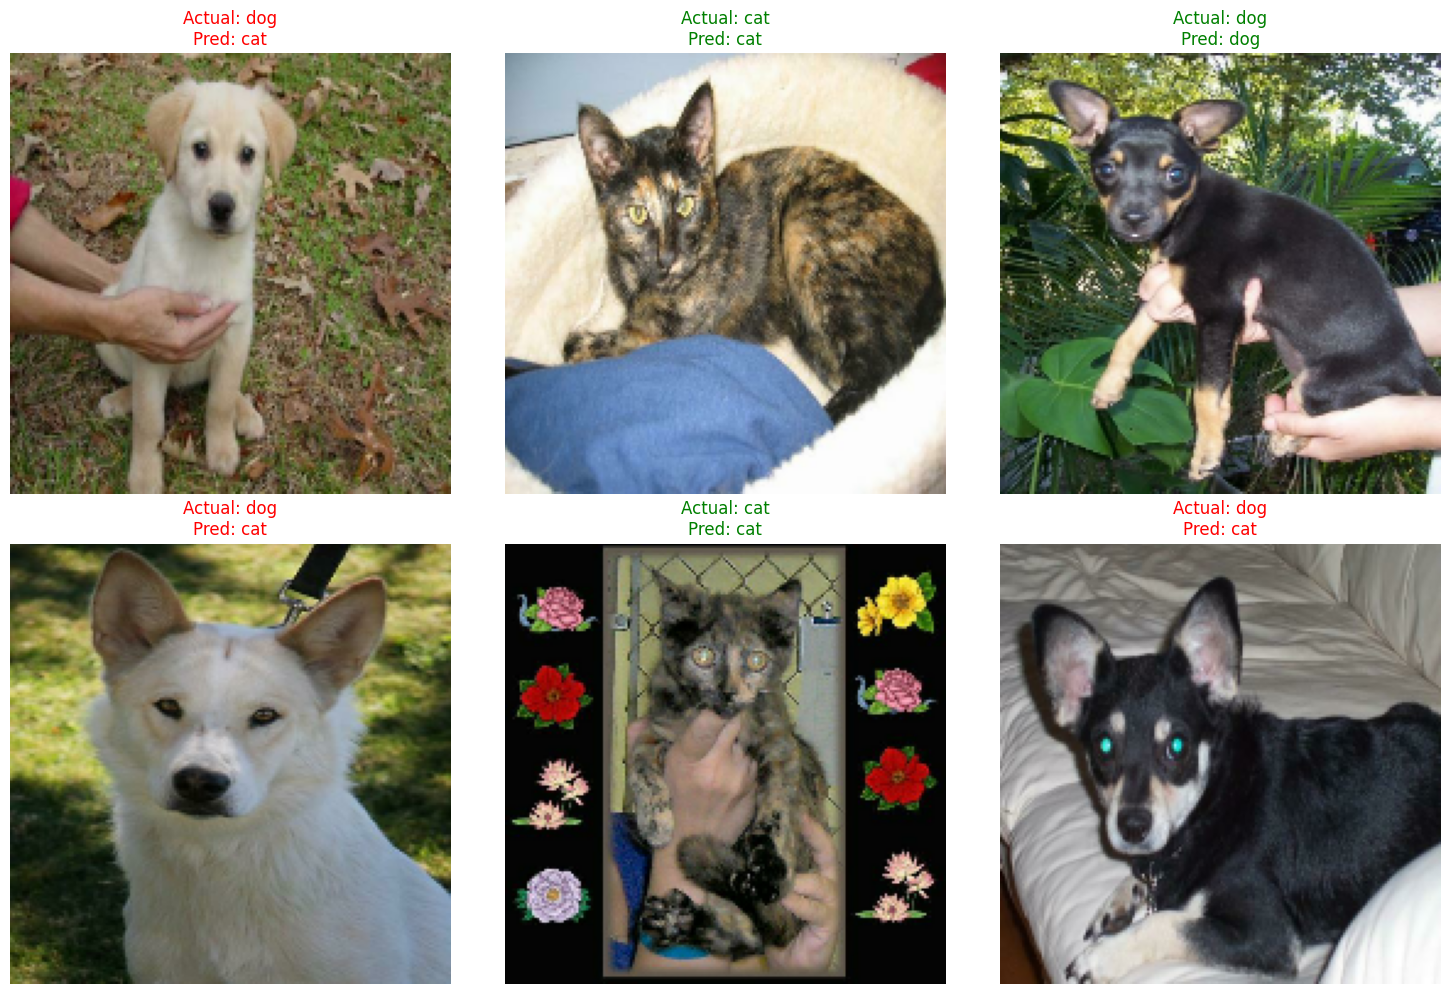

In [92]:
model = keras.models.load_model("./checkpoints/best_model.keras")
display_predictions(model, test_dataset)

## **Probamos con imágenes externas, que descargo de internet**

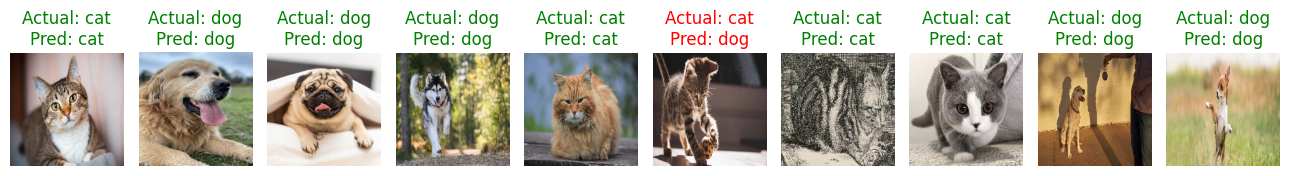

In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def display_custom_predictions(model, image_paths, true_labels, class_names=["cat", "dog"]):
    # Cargar y preprocesar imágenes
    images = []
    for path in image_paths:
        img = tf.keras.utils.load_img(path, target_size=(180, 180))  # Ajustar al tamaño de entrada del modelo
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Crear dimensión de batch
        images.append(img_array)
    
    # Concatenar todas las imágenes
    images_batch = tf.concat(images, axis=0)
    
    # Preprocesamiento específico del modelo (ej: normalización)
    # Si tu modelo requiere normalización, descomenta:
    # images_batch = tf.keras.applications.imagenet_utils.preprocess_input(images_batch)
    
    # Predecir
    preds = model.predict(images_batch, verbose=0)
    preds_binary = (preds > 0.5).astype(int).flatten()
    
    # Configurar plot
    plt.figure(figsize=(13, 7))
    for i in range(len(image_paths)):
        img = images_batch[i].numpy().astype("uint8")
        true_label = class_names[true_labels[i]]
        pred_label = class_names[preds_binary[i]]
        title_color = "green" if true_label == pred_label else "red"
        
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {true_label}\nPred: {pred_label}", color=title_color, fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Uso del código
image_paths = [
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/gatocomuneuropeo-97.jpeg',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/Golden_Retriever_9-year_old.jpg',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/cc909b73-a691-4ea7-ac60-d52f39e6d660_source-aspect-ratio_1600w_0.jpg',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/dog-g6aa17498a_1920.jpg.webp',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/vidas-del-gato-900.jpg',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/gatito-gato-gsc1.jpeg.webp',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/216263bf-4160-4b17-abd0-8c94d2459b43_16-9-discover-aspect-ratio_default_1099866.jpg',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/gato-incendio.jpeg',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/nationalgeographic2780946.webp',
    '/Users/alvarogonzalez/Desktop/PRUEBA PERRO Y GATO/actitudes-curiosas-de-tu-perro.jpg',
]

true_labels = [0, 1, 1, 1, 0, 0, 0, 0, 1, 1]  # 0 = gato, 1 = perro

# Cargar tu modelo entrenado (ejemplo)
# model = tf.keras.models.load_model('mi_modelo.h5')

# Llamar a la función
display_custom_predictions(model, image_paths, true_labels)

### **Pruebo con mi perro**

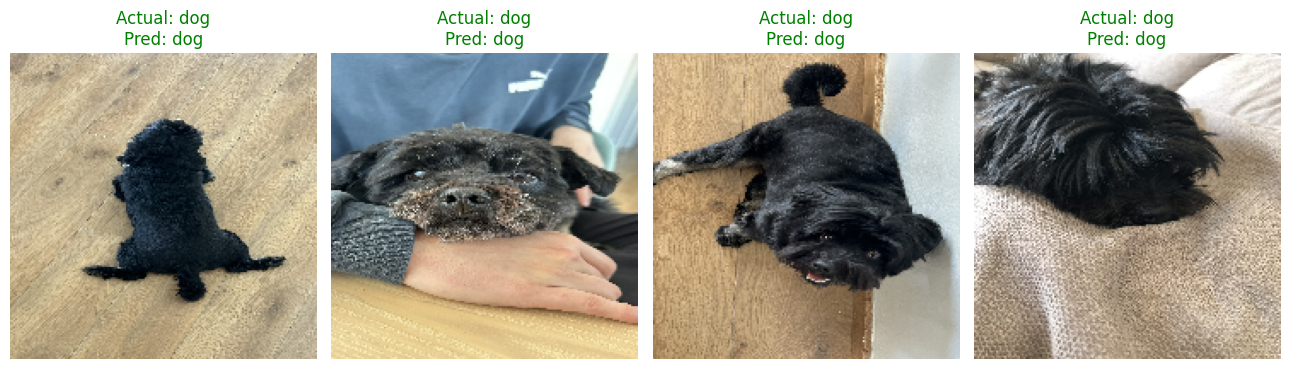

In [59]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def display_custom_predictions(model, image_paths, true_labels, class_names=["cat", "dog"]):
    # Cargar y preprocesar imágenes
    images = []
    for path in image_paths:
        img = tf.keras.utils.load_img(path, target_size=(180, 180))  # Ajustar al tamaño de entrada del modelo
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Crear dimensión de batch
        images.append(img_array)
    
    # Concatenar todas las imágenes
    images_batch = tf.concat(images, axis=0)
    
    # Preprocesamiento específico del modelo (ej: normalización)
    # Si tu modelo requiere normalización, descomenta:
    # images_batch = tf.keras.applications.imagenet_utils.preprocess_input(images_batch)
    
    # Predecir
    preds = model.predict(images_batch, verbose=0)
    preds_binary = (preds > 0.5).astype(int).flatten()
    
    # Configurar plot
    plt.figure(figsize=(13, 7))
    for i in range(len(image_paths)):
        img = images_batch[i].numpy().astype("uint8")
        true_label = class_names[true_labels[i]]
        pred_label = class_names[preds_binary[i]]
        title_color = "green" if true_label == pred_label else "red"
        
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {true_label}\nPred: {pred_label}", color=title_color, fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Uso del código
image_paths = [
    '/Users/alvarogonzalez/Pictures/Photos Library.photoslibrary/resources/derivatives/1/1CBCDA71-77B8-4553-9920-1CD60887509F_1_102_a.jpeg',
    '/Users/alvarogonzalez/Pictures/Photos Library.photoslibrary/resources/derivatives/0/0314AAA5-155B-470E-96BE-C32395B6645A_1_102_a.jpeg',
    '/Users/alvarogonzalez/Pictures/Photos Library.photoslibrary/resources/derivatives/1/1FD3D4FA-BC3D-4A5F-9B71-94B03F834B88_1_102_a.jpeg',
    '/Users/alvarogonzalez/Pictures/Photos Library.photoslibrary/resources/derivatives/9/92C910C8-6AA2-4EB6-B06F-8988787265AE_1_105_c.jpeg',
]

true_labels = [1, 1, 1, 1, 1]  # 0 = gato, 1 = perro

# Cargar tu modelo entrenado (ejemplo)
# model = tf.keras.models.load_model('mi_modelo.h5')

# Llamar a la función
display_custom_predictions(model, image_paths, true_labels)